**Progress summary:**


Revisited data cleaning and turned weapon type, target type, attack type into binary variables. This is more meaningful because some attacks have multiple values for these categories (multiple weapons used, etc). Additionally, they need to be binarized for SVM to treat them correctly (https://www.quora.com/How-can-l-apply-an-SVM-for-categorical-data). However, doing this did not appear to improve performance. 

**to do/questions:**
    
how to run SVC faster - is using a smaller training set reasonable

reporting and interpreting results

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import make_scorer
from sklearn.metrics import f1_score

#does cross-validation and computes average score for the 5 folds
def cv_score(clf, x, y, score_func=accuracy_score):
    result = 0
    nfold = 5
    for train, test in KFold(nfold, random_state = 42).split(x): # split data into train/test groups, 5 times
        clf.fit(x[train], y.iloc[train]) # fit
        result += score_func(clf.predict(x[test]), y.iloc[test]) # evaluate score function on held-out data
    return result / nfold # average

In [3]:
df = pd.read_csv('cleaned.csv')
df['fatal'] = df['nkill'] > 0

In [12]:
explanatory_vars = ['region','crit1','crit2','crit3','suicide','attacktype1','targtype1','individual','weaptype1', 'imonth']

Xtrain, Xtest, ytrain, ytest = train_test_split(df[explanatory_vars].values, df['success'], random_state = 42, test_size = 0.2)

Xtraining, Xholdout, ytraining, yholdout = train_test_split(Xtrain, ytrain, random_state = 42, test_size = 0.2)

print(type(Xtrain), type(ytrain))

<class 'numpy.ndarray'> <class 'pandas.core.series.Series'>


Using logistic regression to predict success:

In [82]:
Log_clf = LogisticRegression()

#ytrain = ytrain.reset_index()

print(cv_score(Log_clf, Xtrain, ytrain))

0.899305413687


In [73]:
Log_clf.fit(Xtraining, ytraining)
print(confusion_matrix(yholdout, Log_clf.predict(Xholdout), labels = [1,0]))
print(classification_report(yholdout, Log_clf.predict(Xholdout)))

[[17591     0]
 [ 1989     0]]
             precision    recall  f1-score   support

          0       0.00      0.00      0.00      1989
          1       0.90      1.00      0.95     17591

avg / total       0.81      0.90      0.85     19580



C:\Users\joshy\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [22]:
print(len(Log_clf.predict(Xholdout)), np.sum(Log_clf.predict(Xholdout)))

19580 19580


The logistic regression classifies every attack as a success. The accuracy score, and unweighted F1 score, are technically high but this doesn't seem very meaningful. Now I'll try regularization:

In [70]:
Cs = [0.001, 0.1, 1, 10, 100]

for c in Cs:
    reg_clf = LogisticRegression(C = c)
    reg_clf.fit(Xtraining, ytraining)
    print(c)
    print(confusion_matrix(yholdout, reg_clf.predict(Xholdout), labels = [1,0]))

#for every regularization parameter, still predicts everything as success

0.001
[[17591     0]
 [ 1989     0]]
0.1
[[17591     0]
 [ 1989     0]]
1
[[17591     0]
 [ 1989     0]]
10
[[17591     0]
 [ 1989     0]]
100
[[17591     0]
 [ 1989     0]]


The classifier still classifies everything as a success. Not sure how to tune logistic regression to try to predict negatives.

Next, random forests:

In [106]:
Rf_clf = RandomForestClassifier(random_state = 42)

Rf_clf.fit(Xtraining, ytraining)

print(confusion_matrix(yholdout, Rf_clf.predict(Xholdout),labels=[1,0]))

print(f1_score(yholdout, Rf_clf.predict(Xholdout)))

[[17427   164]
 [ 1722   267]]
0.948666303756


In [83]:
print(classification_report(yholdout, Rf_clf.predict(Xholdout)))
print(type(classification_report(yholdout, Rf_clf.predict(Xholdout))))

             precision    recall  f1-score   support

          0       0.60      0.13      0.22      1989
          1       0.91      0.99      0.95     17591

avg / total       0.88      0.90      0.87     19580

<class 'str'>


The random forest predicts some failures, but the recall is still very low (0.13) for unsuccessful attacks.

In [88]:
param_grid = {'max_depth':[3,5,10,20,100], 'min_impurity_decrease':[1e-7,1e-6,1e-5, 1e-4, 1e-3, 1e-2]}
scorer = make_scorer(f1_score)
Rf_clf = RandomForestClassifier()
Rf_clf_cv = GridSearchCV(Rf_clf, param_grid, cv = 5, scoring = scorer)
Rf_clf_cv.fit(Xtrain, ytrain)

print(Rf_clf_cv.best_params_)

{'max_depth': 10, 'min_impurity_decrease': 1e-06}


In [90]:
Rf_clf_tuned = RandomForestClassifier(max_depth = 10, min_impurity_decrease = 1e-6)

Rf_clf_tuned.fit(Xtrain,ytrain)
print(classification_report(ytrain, Rf_clf_tuned.predict(Xtrain)))

             precision    recall  f1-score   support

          0       0.68      0.12      0.20      9858
          1       0.91      0.99      0.95     88042

avg / total       0.89      0.91      0.87     97900



Tuning does not make much of a difference.

## Classifing fatality

Moving to fatality rate, which is closer to 50/50 which makes interpreting metrics easier

In [16]:
print(df['fatal'].sum()/df['fatal'].count())

0.453046348957


In [17]:
Xtrain_f, Xtest_f, ytrain_f, ytest_f = train_test_split(df[explanatory_vars].values, df['fatal'], random_state = 42, test_size = 0.2)

Log_clf_f = LogisticRegression()

print(cv_score(Log_clf_f, Xtrain_f, ytrain_f))

0.738764044944


average accuracy score of 0.7387 after cross-validation

In [20]:
Log_clf_f = LogisticRegression()
Log_clf_f.fit(Xtrain_f, ytrain_f)
print(classification_report(ytrain_f, Log_clf_f.predict(Xtrain_f)))
print(accuracy_score(ytrain_f, Log_clf_f.predict(Xtrain_f)))

             precision    recall  f1-score   support

      False       0.74      0.82      0.77     53654
       True       0.74      0.64      0.69     44246

avg / total       0.74      0.74      0.74     97900

0.739039836568


Accuracy score on training data (0.739) is approximately the same as average cross-validation score, so there is no overfitting even without regularization. F1-score is somewhat better for non-fatal attacks (0.77 vs 0.69)

In [21]:
Rf_clf_f = RandomForestClassifier(random_state = 42)

print(cv_score(Rf_clf_f, Xtrain_f, ytrain_f))

0.760847803882


In [22]:
print(classification_report(ytrain_f, Rf_clf_f.predict(Xtrain_f)))
print(accuracy_score(ytrain_f, Rf_clf_f.predict(Xtrain_f)))

             precision    recall  f1-score   support

      False       0.81      0.81      0.81     53654
       True       0.77      0.78      0.77     44246

avg / total       0.79      0.79      0.79     97900

0.792042900919


Average cross-validated score (0.76) is only slightly worse than the accuracy on training data (0.792), so there is only a little overfitting.

In [26]:
param_grid = {'max_depth':[10,20,100,500,1000], 'min_impurity_decrease':[1e-9, 1e-8, 1e-7,1e-6,1e-5, 1e-4, 1e-3, 1e-2]}
scorer = make_scorer(f1_score)
Rf_clf_f = RandomForestClassifier()
Rf_clf_fcv = GridSearchCV(Rf_clf_f, param_grid, cv = 5, scoring = scorer)
Rf_clf_fcv.fit(Xtrain_f, ytrain_f)

print(Rf_clf_fcv.best_params_)

{'max_depth': 100, 'min_impurity_decrease': 1e-06}


best params: max_depth 100, min_impurity_decrease 1e-06

In [27]:
Rf_clf_f_tuned = RandomForestClassifier(max_depth = 100, min_impurity_decrease = 1e-06)

Rf_clf_f_tuned.fit(Xtrain_f,ytrain_f)

print(cv_score(Rf_clf_f_tuned, Xtrain_f, ytrain_f))

0.766894790603


Score after tuning is 0.767, which is a very small improvement over the untuned model.

Support vector machines:

In [108]:
Sv_clf_f = SVC()

Sv_clf_f.fit(Xtrain_f, ytrain_f)

print(accuracy_score(ytrain_f, Sv_clf_f.predict(Xtrain_f)))
#accuracy is 0.76326. This takes a long time (>10 minutes) to run

0.763258426966


In [ ]:
from sklearn.svm import SVC

Sv_clf_f = SVC()

#this takes forever...
print(cv_score(Sv_clf_f, Xtrain_f, ytrain_f))

potential variables to add: country, target subtype, number of perpetrators, 

## After Binarization

In [4]:
df = pd.read_csv('cleaned.csv')
df['fatal'] = df['nkill'] > 0

In [5]:
cols = list(df.columns.values)

In [6]:
explanatory_vars = cols[2:6] + [cols[7]] + [cols[14]] + cols[23:72]

print(explanatory_vars)

['region', 'crit1', 'crit2', 'crit3', 'suicide', 'individual', 'North America', 'Central America', 'South America', 'East Asia', 'SE Asia', 'South Asia', 'Central Asia', 'West Europe', 'East Europe', 'ME and North Africa', 'Sub-Saharan Africa', 'Biological', 'Chemical', 'Radiological', 'Nuclear', 'Firearms', 'Explosives', 'Fake Weapon', 'Incendiary', 'Melee', 'Vehicle', 'Sabotage Equipment', 'Assassination', 'Armed Assault', 'Bombing', 'Hijacking', 'Hostage (Barricade)', 'Kidnapping', 'Infrastructure', 'Business', 'Government', 'Police', 'Military', 'Abortion', 'Aviation', 'Diplomatic', 'Education', 'FoodWater', 'Media', 'Maritime', 'NGO', 'Private', 'Religious', 'Telecommunication', 'Terrorists', 'Tourists', 'Transportation', 'Utilities', 'Violent Parties']


In [7]:
Xtrain_f, Xtest_f, ytrain_f, ytest_f = train_test_split(df[explanatory_vars].values, df['fatal'], random_state = 42, test_size = 0.2)

In [8]:
Log_clf_f = LogisticRegression()

print(cv_score(Log_clf_f, Xtrain_f, ytrain_f))

0.766016343207


In [12]:
Cs = [0.001, 0.1, 1, 10, 100, 1000]

for c in Cs:
    reg_clf = LogisticRegression(C = c)
    reg_clf.fit(Xtrain_f, ytrain_f)
    print(cv_score(reg_clf, Xtrain_f, ytrain_f))

0.750275791624
0.76544433095
0.766016343207
0.766118488253
0.766138917263
0.766118488253


In [19]:
Rf_clf_f = RandomForestClassifier(random_state = 42)

print(cv_score(Rf_clf_f, Xtrain_f, ytrain_f))

0.769397344229


In [20]:
print(accuracy_score(ytrain_f, Rf_clf_f.predict(Xtrain_f)))

0.784841675179


In [31]:
Xtrain_f, Xtest_f, ytrain_f, ytest_f = train_test_split(df[explanatory_vars].values, df['fatal'], random_state = 42, test_size = 0.7)

In [32]:
Sv_clf_f = SVC(kernel = 'linear')

Sv_clf_f.fit(Xtrain_f, ytrain_f)

print(accuracy_score(ytrain_f, Sv_clf_f.predict(Xtrain_f)))

0.75841686642


Training on 30% of the data with a linear kernel, I get accuracy of 0.758 on the training data.

In [33]:
Sv_clf_f = SVC()

Sv_clf_f.fit(Xtrain_f, ytrain_f)

print(accuracy_score(ytrain_f, Sv_clf_f.predict(Xtrain_f)))

0.759070603617


With rbf kernel (sklearn default), accuracy is 0.759 on training data

In [35]:
Sv_clf_f = SVC(kernel = 'linear')
print(cv_score(Sv_clf_f, Xtrain_f, ytrain_f))

0.757463648466


Cross-validated score for a linear kernel is 0.7574, indicating low overfitting.

In [1]:
from sklearn.decomposition import PCA

In [9]:
pca = PCA(0.95)
#model.fit_transform(samples)
pca.fit(Xtrain_f)

PCA(copy=True, iterated_power='auto', n_components=0.95, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

In [11]:
print(pca.n_components_)

13


In [12]:
pca_Xtrain_f = pca.transform(Xtrain_f)

Log_clf_f = LogisticRegression()
print(cv_score(Log_clf_f, pca_Xtrain_f, ytrain_f))

0.735097037794


After PCA, cross-validated score went down to 0.735 (from 0.766 before PCA)

In [13]:
Sv_clf_f = SVC()
Sv_clf_f.fit(pca_Xtrain_f, ytrain_f)

print(accuracy_score(ytrain_f, Sv_clf_f.predict(pca_Xtrain_f)))

0.751756894791


run time 20 min, accuracy on training data = 0.751756894791

In [15]:
Log_clf_f = LogisticRegression()
Log_clf_f.fit(Xtrain_f, ytrain_f)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [20]:
print(type(Log_clf_f.predict(Xtrain_f)))
print(type(ytrain_f))
print(type(Xtrain_f))

<class 'numpy.ndarray'>
<class 'pandas.core.series.Series'>
<class 'numpy.ndarray'>


In [28]:
wrong_idx = []
predictions = Log_clf_f.predict(Xtrain_f)
count = 0
for i, v in ytrain_f.iteritems():
    if v != predictions[count]:
        wrong_idx.append(i)
    count += 1
print(len(wrong_idx))
print(1 - len(wrong_idx)/len(ytrain_f))
print(accuracy_score(ytrain_f, Log_clf_f.predict(Xtrain_f)))

22920
0.7658835546475996
0.765883554648


In [31]:
wrong_df = df.iloc[wrong_idx]
wrong_df.describe()

,iyear,imonth,region,crit1,crit2,crit3,success,suicide,attacktype1,attacktype2,...,Maritime,NGO,Private,Religious,Telecommunication,Terrorists,Tourists,Transportation,Utilities,Violent Parties
count,22920.000000,22920.000000,22920.000000,22920.000000,22920.000000,22920.00000,22920.000000,22920.000000,22920.000000,678.000000,...,22920.000000,22920.000000,22920.000000,22920.000000,22920.000000,22920.000000,22920.000000,22920.000000,22920.000000,22920.000000
mean,2004.184250,6.563743,7.539136,0.987522,0.994546,0.84219,0.869590,0.006021,2.758639,3.710914,...,0.001920,0.004756,0.311780,0.022906,0.002836,0.017016,0.002836,0.047513,0.006850,0.009599
std,11.859712,3.346106,2.796585,0.111009,0.073649,0.36457,0.336761,0.077362,1.174596,2.275468,...,0.043773,0.068799,0.463231,0.149606,0.053179,0.129333,0.053179,0.212738,0.082482,0.097503
min,1970.000000,1.000000,1.000000,0.000000,0.000000,0.00000,0.000000,0.000000,1.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1992.000000,4.000000,6.000000,1.000000,1.000000,1.00000,1.000000,0.000000,2.000000,2.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,2010.000000,7.000000,8.000000,1.000000,1.000000,1.00000,1.000000,0.000000,3.000000,2.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,2014.000000,9.000000,10.000000,1.000000,1.000000,1.00000,1.000000,0.000000,3.000000,7.000000,...,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,2016.000000,12.000000,12.000000,1.000000,1.000000,1.00000,1.000000,1.000000,8.000000,8.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


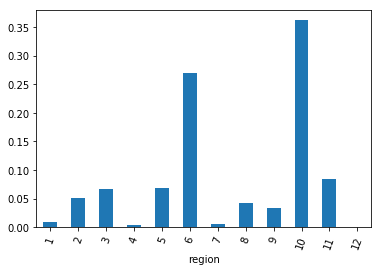

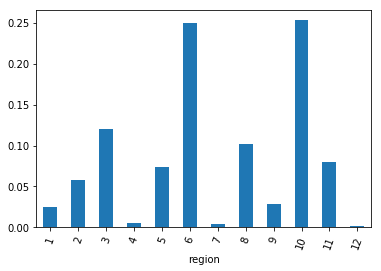

In [53]:
import matplotlib.pyplot as plt

wrong_region = wrong_df.groupby('region').size()/22920
region = df.groupby('region').size()/122376

_ = wrong_region.plot(kind='bar', rot = 70)
plt.show()
_ = region.plot(kind='bar', rot = 70)
plt.show()

Region 10 (ME and North Africa) is a a bit overrepresented.

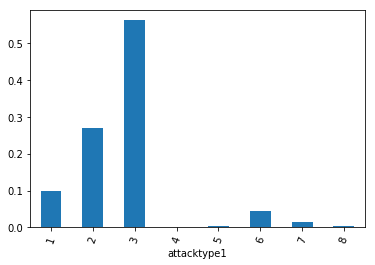

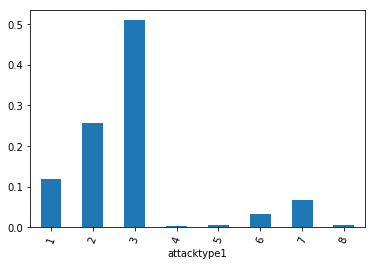

In [54]:
wrong_attacktype = wrong_df.groupby('attacktype1').size()/22920
attacktype = df.groupby('attacktype1').size()/122376

_ = wrong_attacktype.plot(kind='bar', rot = 70)
plt.show()
_ = attacktype.plot(kind='bar', rot = 70)
plt.show()

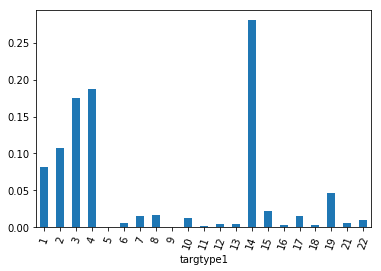

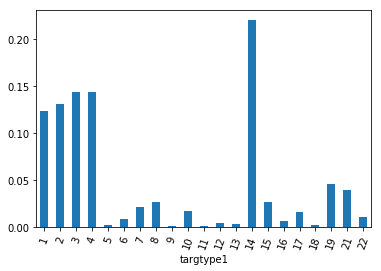

In [51]:
wrong_targtype = wrong_df.groupby('targtype1').size()/22920
targ_type = df.groupby('targtype1').size()/122376

_ = wrong_targtype.plot(kind='bar', rot = 70)
plt.show()
_ = targ_type.plot(kind='bar', rot = 70)
plt.show()